In [62]:
import os
import ember
import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve

### Creating the baseline model

In [4]:
import pandas as pd

In [7]:
ember.create_vectorized_features("data/ember2018/")
ember.create_metadata("data/ember2018/")

Vectorizing training set


100%|████████████████████████████████████████████████████████████████████████| 800000/800000 [06:05<00:00, 2190.28it/s]


Vectorizing test set


100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [01:28<00:00, 2262.52it/s]


,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,,train
...,...,...,...,...,...
999995,e033bc4967ce64bbb5cafdb234372099395185a6e0280c...,2018-12,1,zbot,test
999996,c7d16736fd905f5fbe4530670b1fe787eb12ee86536380...,2018-12,1,flystudio,test
999997,0020077cb673729209d88b603bddf56b925b18e682892a...,2018-12,0,,test
999998,1b7e7c8febabf70d1c17fe3c7abf80f33003581c380f28...,2018-12,0,,test


In [47]:
%%time
X_train, y_train, X_test, y_test = ember.read_vectorized_features("data/ember2018/")
emberdf = ember.read_metadata("data/ember2018/")

Wall time: 1.33 s


In [64]:
data_dir = "data/ember2018/"

In [72]:
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()

In [65]:
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))

In [71]:
alt.Chart(gbdf).mark_bar().encode(
    alt.X('subset:O', axis=alt.Axis(title='Subset')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=["#00b300", "#3333ff", "#ff3333"]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"])))

alt.Chart(...)

In [66]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [67]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9964289467999999

Ember Model Performance at 1% FPR:
Threshold: 0.8336
False Positive Rate: 1.000%
False Negative Rate: 3.502%
Detection Rate: 96.498%

Ember Model Performance at 0.1% FPR:
Threshold: 0.9996
False Positive Rate: 0.098%
False Negative Rate: 13.192%
Detection Rate: 86.80799999999999%


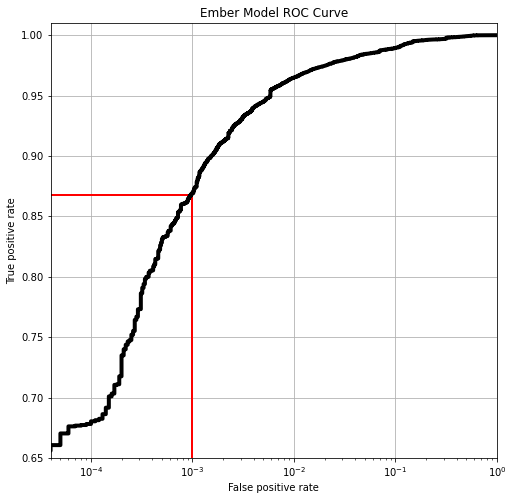

In [68]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")